# Описание

В этом ноутбуке будет построена модель предсказания риска развития сердечно-сосудистых заболеваний.

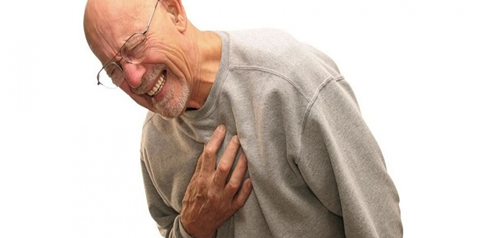

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci <br>
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
df = pd.read_csv(r'C:\Users\Максим\Desktop\Аналитика данных\Datasets\heart_cleveland_upload.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
df.shape

(297, 14)

age: age in years <br>
sex: sex (1 = male; 0 = female)<br>
cp: chest pain type<br>
-- Value 0: typical angina (angina это стенокардия)<br>
-- Value 1: atypical angina<br>
-- Value 2: non-anginal pain<br>
-- Value 3: asymptomatic<br>
trestbps: resting blood pressure (in mm Hg on admission to the hospital)<br>
chol: serum cholestoral in mg/dl<br>
fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)<br>
restecg: resting electrocardiographic results<br>
-- Value 0: normal<br>
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)<br>
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria<br>
thalach: maximum heart rate achieved<br>
exang: exercise induced angina (1 = yes; 0 = no)<br>
oldpeak = ST depression induced by exercise relative to rest (in mm, achieved by subtracting the lowest ST segment points during exercise and rest)<br>
slope: the slope of the peak exercise ST segment<br>
-- Value 0: upsloping<br>
-- Value 1: flat<br>
-- Value 2: downsloping<br>
ca: number of major vessels (0-3) colored by fluoroscopy. Major cardial vessels are as goes: aorta, superior vena cava, inferior vena cava, pulmonary artery (oxygen-poor blood --> lungs), pulmonary veins (oxygen-rich blood --> heart), and coronary arteries (supplies blood to heart tissue).
Radioactive dye is introduced to the body followed by x-ray imaging to detect any structural abnormalities present in the heart. The quantity of vessels colored is positively correlated with presence of heart disease.

thal: 0 = normal; 1 = fixed defect (heart tissue can't absorb thallium both under stress and in rest); 2 = reversible defect (heart tissue is unable to absorb thallium only under the exercise portion of the test)

Thallium testing is a method where the radioactive element thallium (Tl) is introduced to the body through an IV injection, followed by nuclear imaging of the heart with a gamma camera which reveals structural issues and abnormalities of the heart by showing whether if the isotope was absorbed by heart tissue under high (exercise) and low (rest) stress conditions.
and the label<br>
condition: 0 = no disease, 1 = disease<br>

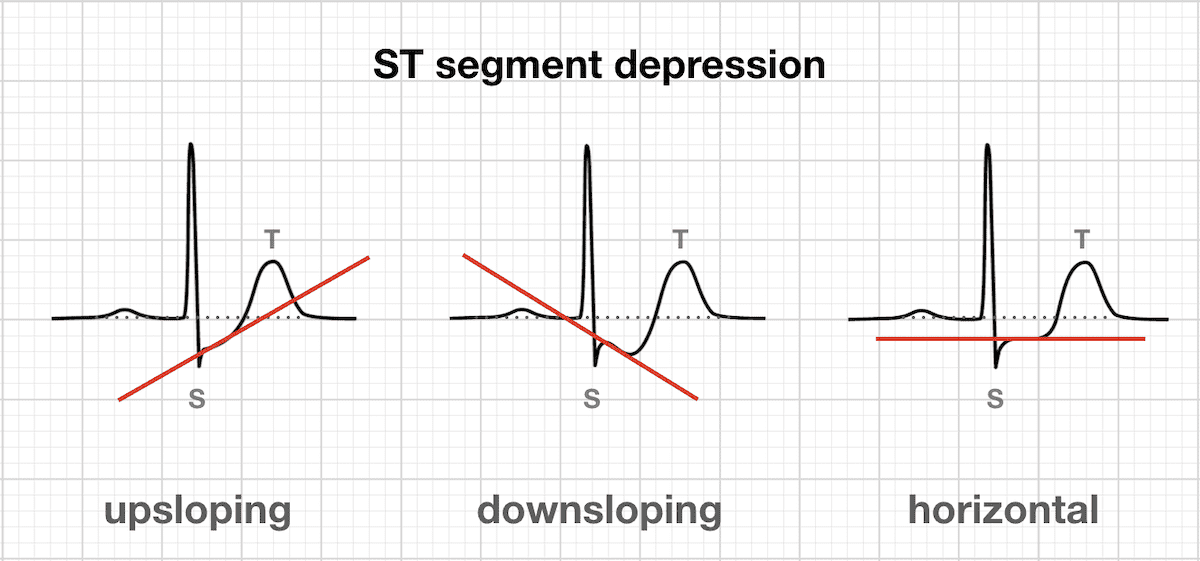

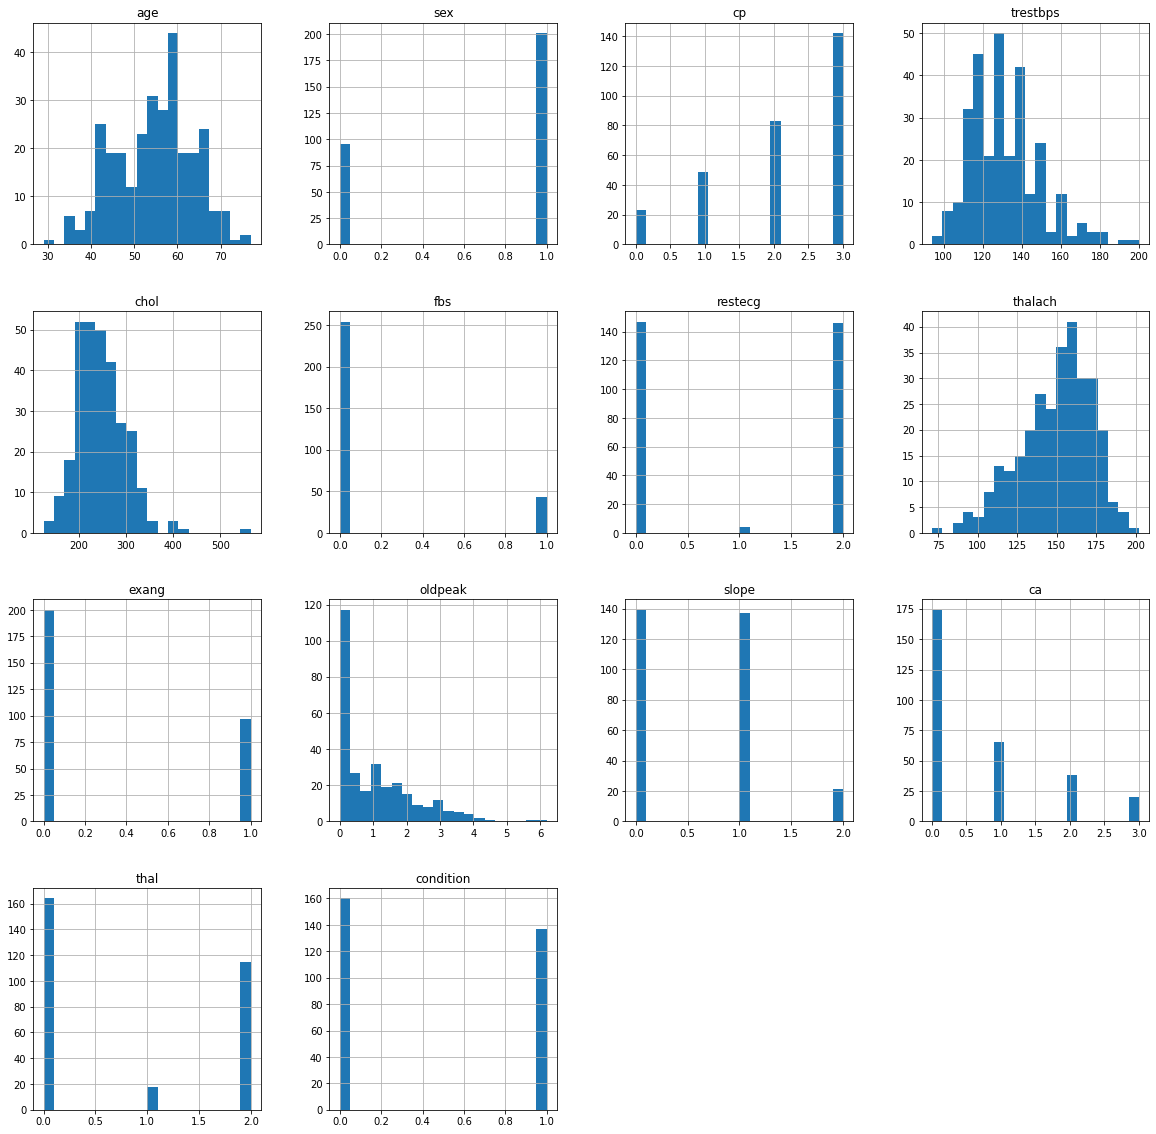

In [5]:
df.hist(bins=20, figsize=(20,20));

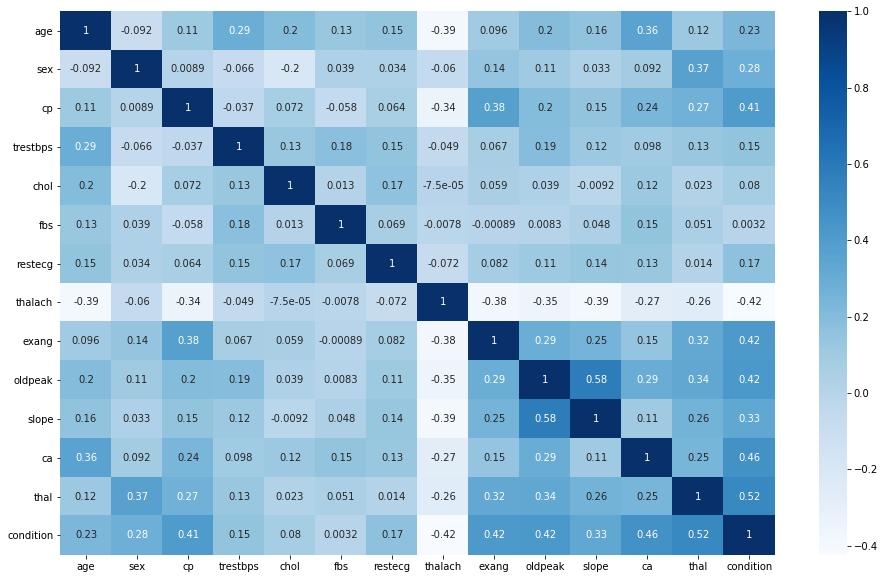

In [6]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), cmap='Blues', annot=True);

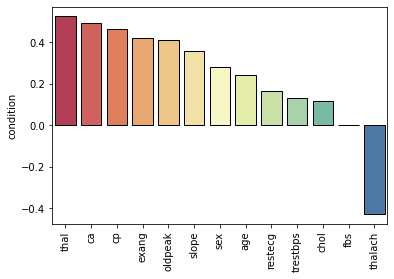

In [20]:
corr_data = df.corr(method='spearman')['condition'].sort_values(ascending=False)[1:]
sns.barplot(x=corr_data.index, y=corr_data, palette='Spectral', ec='k')
plt.xticks(rotation=90);

Наибольшая корреляция наблюдается в признаках thal (использование таллия), ca (кол-во основных кровеносных сосудов, подкрашенных при рентгеноскопии), oldpeak (один из показателей экг), exang (появилась ли стенокардия во время физ.нагрузок) и cp (тип боли в груди).

In [8]:
from pandas_profiling import ProfileReport

In [9]:
profile = ProfileReport(df, title="Анализ данных о риске развития ССЗ")

# Базовая модель МО

## Модели

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from feature_engine.outliers import Winsorizer

In [118]:
X = df.drop(columns=['condition'])
y = df.condition

Дизбаланса целевой переменной не наблюдается

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [120]:
scaler = StandardScaler()
log_tr = FunctionTransformer(np.log1p)
win = Winsorizer()

### Логистическая регрессия

In [121]:
logreg = LogisticRegression()

In [148]:
lr_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', logreg)
])

In [149]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('log', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('outliers', Winsorizer()), ('model', LogisticRegression())])

In [150]:
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        38
           1       0.78      0.84      0.81        37

    accuracy                           0.80        75
   macro avg       0.80      0.80      0.80        75
weighted avg       0.80      0.80      0.80        75



### Градиентный бустинг

In [53]:
from xgboost import XGBClassifier

In [153]:
xgb = XGBClassifier()

xgb_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', xgb)
])

In [152]:
xgb_model.fit(X_train, y_train)
print(classification_report(y_test, xgb_model.predict(X_test)))

[22:06:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        38
           1       0.74      0.76      0.75        37

    accuracy                           0.75        75
   macro avg       0.75      0.75      0.75        75
weighted avg       0.75      0.75      0.75        75



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [156]:
rf = RandomForestClassifier()

rf_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', rf)
])

In [157]:
rf_model.fit(X_train, y_train)
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        38
           1       0.75      0.81      0.78        37

    accuracy                           0.77        75
   macro avg       0.78      0.77      0.77        75
weighted avg       0.78      0.77      0.77        75



### KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [160]:
knn = KNeighborsClassifier()

knn_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', knn)
])

In [161]:
knn_model.fit(X_train, y_train)
print(classification_report(y_test, knn_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.83      0.78      0.81        37

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



### Catboost

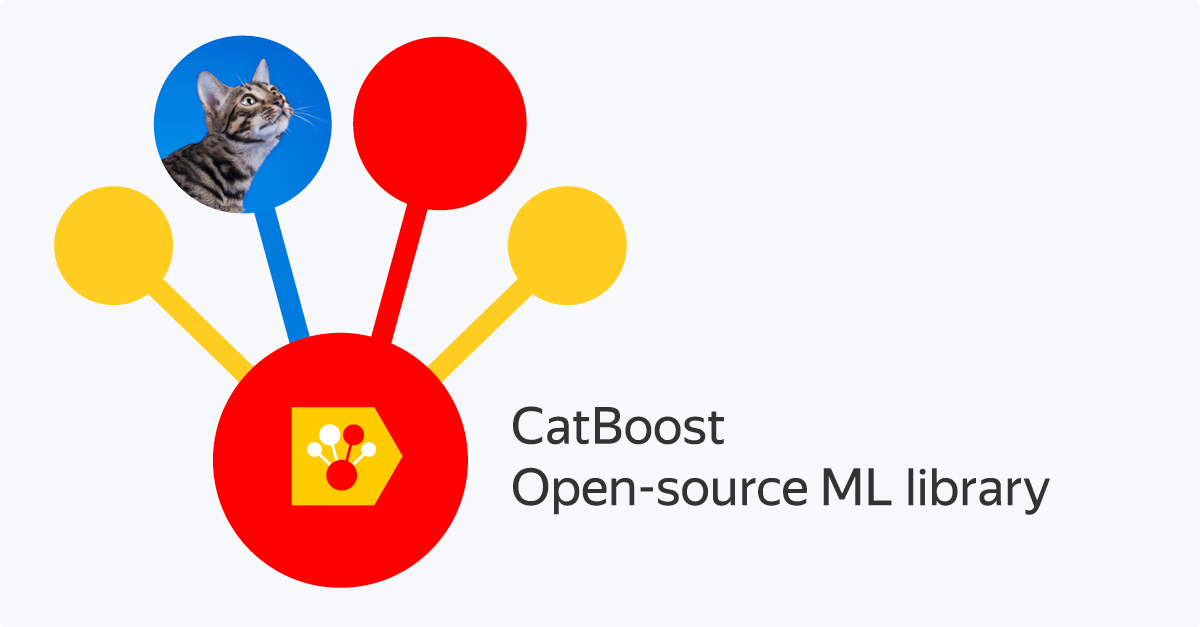

In [62]:
from catboost import CatBoostClassifier, Pool

In [164]:
cat = CatBoostClassifier(verbose=0, eval_metric='AUC')

cat_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', cat)
])

In [165]:
cat_model.fit(X_train, y_train, model__plot=True)
print(classification_report(y_test, cat_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        38
           1       0.79      0.84      0.82        37

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



Catboost и KNN показали себя лучше всех 

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


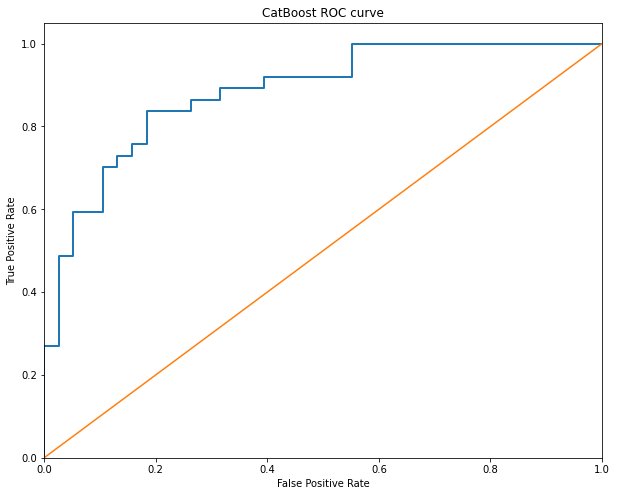

In [140]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC curve')
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


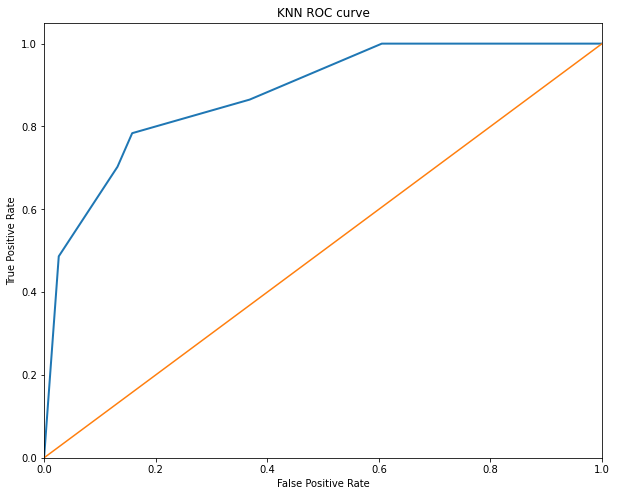

In [141]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC curve')
plt.show()

In [66]:
from joblib import dump, load

In [67]:
dump(cat, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\cat_uci.joblib') 

cat = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\cat_uci.joblib')

## Важность признаков

In [68]:
import shap
shap.initjs()

In [69]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


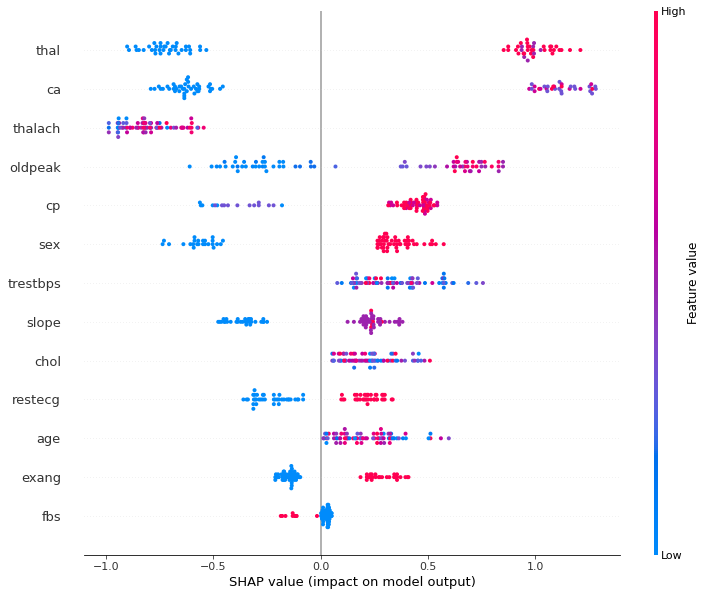

In [70]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_size=(12, 10))

# Улучшение Catboost

In [168]:
cat = CatBoostClassifier(verbose=0, loss_function='Logloss', learning_rate=0.001)

In [169]:
cat_model = Pipeline([
    ('log', log_tr),
    ('outliers', win),
    ('model', cat)
])

In [173]:
cat_model.fit(X_train, y_train, model__plot=True)
print(classification_report(y_test, cat_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        38
           1       0.84      0.86      0.85        37

    accuracy                           0.85        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75



In [174]:
from sklearn import set_config
set_config(display='diagram')

In [175]:
cat_model

Pipeline(steps=[('log', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('outliers', Winsorizer()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000020D4BE80FD0>)])